In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lib
from lib import data_dis, data_ref, data_vst

import numpy as np
from ksvd import ApproximateKSVD
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit

In [3]:
image_ref = np.fromfile('data/nu.bin', dtype=np.float64).reshape(100,100).T
image_vst = np.fromfile('data/fz.bin', dtype=np.float64).reshape(100,100).T
image_dis = np.fromfile('data/z.bin', dtype=np.float64).reshape(100,100).T

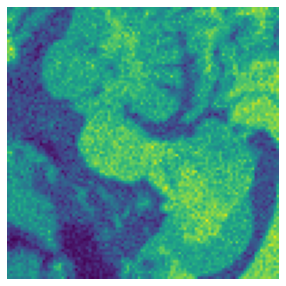

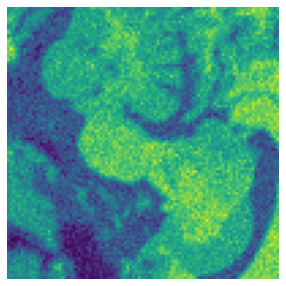

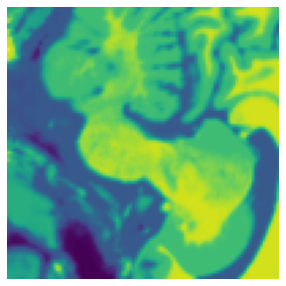

In [4]:
lib.plot_image(image_dis, size=5)
lib.plot_image(image_vst, size=5)
lib.plot_image(image_ref, size=5)


In [5]:
D, A, patches_restored, img_restored = lib.ksvd_filtering(image_vst)

/home/alexkkir/ai-masters/linal/project/lib/blocks_github.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


MAE: 0.732, Nonzero: 1


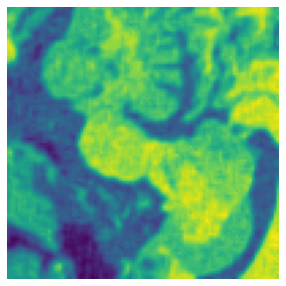

In [6]:
lib.plot_image(img_restored, size=5)

In [7]:
I = lib.get_I(A)
M = lib.get_M(A)
CSS = lib.get_CSS(A, M, I)

100%|██████████| 9409/9409 [00:10<00:00, 866.83it/s] 


In [45]:
CC = lib.nonlocalfiltering.get_CC(CSS, patches_restored, th=0.15)
np.mean([len(x) for x in CC.values()])

100%|██████████| 9409/9409 [00:54<00:00, 172.71it/s]


78.96758422786694

In [46]:
patches_svd = lib.make_svd(CC, patches_restored.shape, n_truncate=1)

In [47]:
img_svd = lib.reconstruct_from_patches_2d(patches_svd.reshape(-1, 4, 4), image_dis.shape)

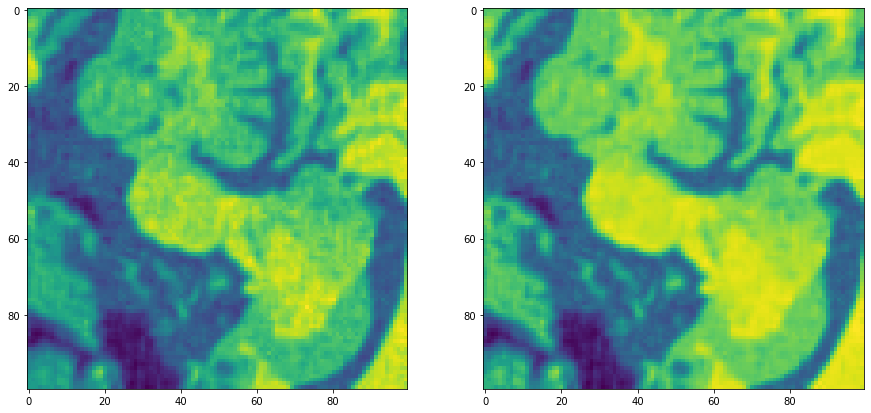

In [48]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_restored)
plt.subplot(1, 2, 2)
plt.imshow(img_svd)

In [49]:
img_restored - img_svd

array([[-0.56346402, -0.57766893, -0.42879203, ...,  0.11172745,
        -0.23772763, -0.23486079],
       [-0.51536401, -0.12681364, -0.11566626, ...,  0.08521592,
        -0.10367154, -0.11865354],
       [-0.07456919,  0.16063225,  0.0759908 , ...,  0.04564247,
        -0.01081993, -0.40682317],
       ...,
       [-0.30962651, -0.37930414, -0.41343385, ...,  0.38106113,
         0.61656777,  1.04688458],
       [-0.37931102, -0.31870917, -0.45017055, ...,  0.54808775,
         0.78275342, -0.05817729],
       [-0.35936178, -0.31563947, -0.25916046, ...,  0.89907214,
         0.76516427,  0.48369682]])

In [191]:
GI = D.sum(axis=1)
GI.shape

(20,)

In [192]:
tmp

array([0.05197152, 0.04601977, 0.0662132 , 0.0452758 , 0.04453183,
       0.05080242, 0.04485067, 0.05069614, 0.04400043, 0.05175895,
       0.05919864, 0.04676374, 0.05664789, 0.06759486, 0.04655117,
       0.04931449, 0.03879265, 0.04485067, 0.04538208, 0.04878308])

In [193]:
lib.ksvd._get_weights(A)

array([0.05197152, 0.04601977, 0.0662132 , 0.0452758 , 0.04453183,
       0.05080242, 0.04485067, 0.05069614, 0.04400043, 0.05175895,
       0.05919864, 0.04676374, 0.05664789, 0.06759486, 0.04655117,
       0.04931449, 0.03879265, 0.04485067, 0.04538208, 0.04878308])

In [194]:
A @ lib.ksvd._get_weights(A)

array([-0.11326536,  0.12670803,  0.20586505, ..., -0.08239798,
       -0.09191052,  0.07859728])

In [215]:
blocks_weights = np.abs(A @ lib.ksvd._get_weights(A))
blocks_weights.shape

(9409,)

In [216]:
weighted_im = lib.reconstruct_from_patches_2d((patches_svd * blocks_weights[:, None]).reshape(-1, 4, 4), image_dis.shape)

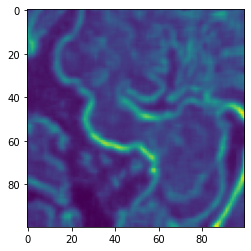

In [221]:
plt.imshow(weighted_im)

In [222]:
weights_for_im = lib.reconstruct_from_patches_2d((np.ones_like(patches_svd) * blocks_weights[:, None]).reshape(-1, 4, 4), image_dis.shape)

In [223]:
weights_for_im


array([[0.11326536, 0.1199867 , 0.14861281, ..., 0.17479393, 0.17067621,
        0.15288093],
       [0.16541717, 0.15898016, 0.18105015, ..., 0.17787723, 0.16196009,
        0.14997671],
       [0.15788292, 0.17142856, 0.19948057, ..., 0.16930587, 0.14611654,
        0.13943657],
       ...,
       [0.08974356, 0.09807186, 0.09185644, ..., 0.08871785, 0.08366919,
        0.07777893],
       [0.0887084 , 0.09131499, 0.08368011, ..., 0.08459583, 0.08467171,
        0.08029858],
       [0.10542254, 0.11262947, 0.10132797, ..., 0.08430193, 0.0852539 ,
        0.07859728]])

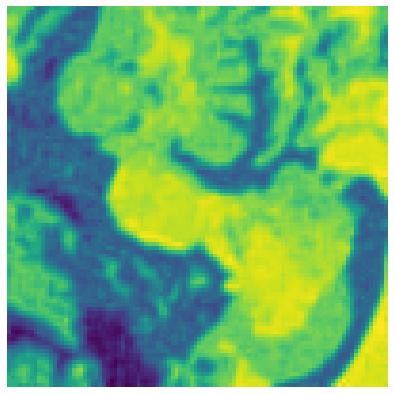

In [224]:
weighed_image = weighted_im / weights_for_im
lib.plot_image(weighed_image, size=7)

In [234]:
weighed_image_2 = lib.nonlocalfiltering.averaging_patch(A, patches_svd, image_ref.shape)

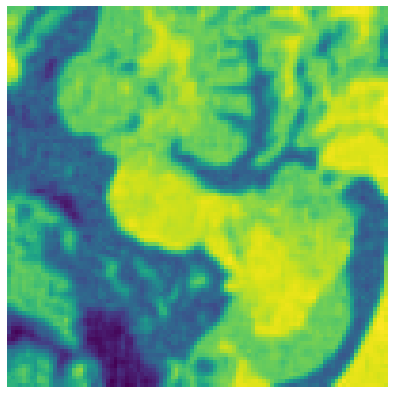

In [235]:
lib.plot_image(weighed_image_2, size=7)

In [238]:
lib.pathces2image(patches_svd, image_dis.shape)

array([[ 9.08572801,  9.08867806,  9.21776217, ...,  9.813807  ,
         8.9858123 ,  9.2387925 ],
       [ 9.02415815,  9.44730384,  9.32653686, ...,  9.88299079,
         9.24539086,  9.44962177],
       [ 9.92802747, 10.06306238,  9.8495848 , ...,  9.7333696 ,
         9.33949184,  9.36398143],
       ...,
       [ 8.15276186,  7.69956826,  8.2407351 , ..., 11.42235844,
        11.55650352, 11.62803485],
       [ 7.97232602,  8.10664616,  8.1615826 , ..., 11.53711418,
        11.57296159, 11.63779245],
       [ 8.12305788,  8.06571962,  7.89844663, ..., 11.74323531,
        11.6315865 , 11.38463626]])

Text(0.05, 0.95, '123\n321\n')

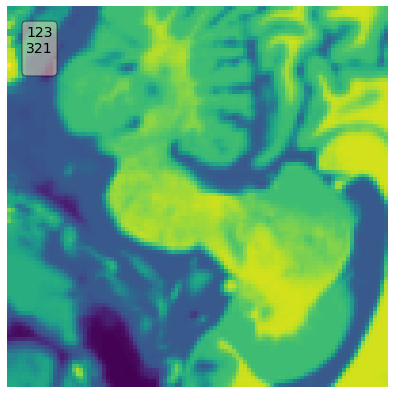

In [255]:
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(image_ref)
ax.axis('off')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, '123\n321\n', transform=ax.transAxes, fontsize=14,
    verticalalignment='top', bbox=props)